# Fine-tuning SpeechT5 para español

This notebook demonstrates how to fine-tune the SpeechT5 model from 🤗 Transformers on the **text-to-speech** task.

The unique thing about SpeechT5 is that the model is first pre-trained on a combination of speech-to-text and text-to-speech data, so that it learns a unified space of hidden representations shared by both text and speech. This allows us to fine-tune the same pretrained model on different tasks. Read more about SpeechT5 [in our blog post](https://huggingface.co/blog/speecht5).

In this notebook we will start from an existing fine-tuned TTS model that was originally trained on English speech from LibriTTS, and fine-tune it for the Dutch language using the VoxPopuli dataset.

This TTS model will support multiple speakers through x-vector speaker embeddings.

## Instalamos los paquetes necesarios
Instalamos datasets de la libreria de Hugging Face que tiene varios conjuntos de datos.

Sound file es una biblioteca para leer y escribir archivos de audio

SpeechBrain es un toolkit para procesamiento de voz como sintetiz, reconocimiento, etc. Sirve para probar modelos o desarrollarlos.

Por ejemplo:
from speechbrain.pretrained import Tacotron2

** Usar un modelo TTS preentrenad**o
tts = Tacotron2.from_hparams(source="speechbrain/tts-tacotron2-ljspeech", savedir="tmpdir")
mel_output, wav_output, alignment = tts("Hello, how are you?")
tts.save_audio(wav_output, "output.wav")

In [ ]:
!pip install datasets soundfile speechbrain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.8/824.8 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 23.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 r

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-wmwrvk_d
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-wmwrvk_d
  Resolved https://github.com/huggingface/transformers.git to commit 3a8eb74668e9c2cc563b2f5c62fac174797063e0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.47.0.dev0-py3-none-any.whl size=10101071 sha256=75aa164e4233ee9e2c55c98f0e744b4acf4d0d429265c7700aad68ecc750b464
  Stored in directory: /tmp/pip-ephem-wheel-cache-k__cjmsz/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2


In [ ]:
!pip install --upgrade accelerate

accelerate es una biblioteca de HF que sirve para ejecutar modelos en multiples cpus o gpus.

Verificamos nuestra GPU

In [ ]:
!nvidia-smi

Sat Nov 23 17:44:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--



```
# Tiene formato de código
```
## Cargar el modelo

Comenzaremos con SpeechT5 y lo afinaremos nuevamente pero para un nuevo idioma.


In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

## Cargar el conjunto de datos

Afinaremos el modelo utilizando ejemplos en español (código de idioma `es`) del conjunto VoxPopuli.

VoxPopuli es un corpus multilingüe de voz a gran escala que contiene datos recopilados de grabaciones de eventos del Parlamento Europeo entre 2009 y 2020. Incluye datos de audio etiquetados con transcripciones para 15 idiomas europeos.

Puedes encontrar [VoxPopuli en el Hugging Face Hub](https://huggingface.co/datasets/facebook/voxpopuli). Allí, puedes escuchar muestras de audio en cualquiera de los 15 idiomas europeos utilizando el visor de datos del conjunto.

Es importante notar que VoxPopuli, o cualquier otro conjunto de datos de reconocimiento automático de voz (ASR), no es necesariamente el mejor para entrenar modelos de TTS. Las características que lo hacen útil para ASR, como la presencia de mucho ruido en el audio, suelen ser lo que queremos evitar en TTS. Sin embargo, los conjuntos de datos de TTS de alta calidad, multilingües y con múltiples hablantes son menos fáciles de encontrar que los conjuntos de ASR.

In [ ]:
from datasets import load_dataset, Audio

# Cargar solo el 1% del dataset de entrenamiento
dataset = load_dataset(
    "facebook/voxpopuli",
    "es",  # Código de idioma para español
    split="train[:15%]"  # Cambiar el porcentaje según tus necesidades
)

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

voxpopuli.py:   0%|          | 0.00/8.84k [00:00<?, ?B/s]

The repository for facebook/voxpopuli contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/voxpopuli.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


data/n_files.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

asr_train.tsv:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

asr_dev.tsv:   0%|          | 0.00/722k [00:00<?, ?B/s]

asr_test.tsv:   0%|          | 0.00/706k [00:00<?, ?B/s]

train_part_0.tar.gz:   0%|          | 0.00/1.86G [00:00<?, ?B/s]

train_part_1.tar.gz:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

train_part_2.tar.gz:   0%|          | 0.00/1.86G [00:00<?, ?B/s]

train_part_3.tar.gz:   0%|          | 0.00/1.86G [00:00<?, ?B/s]

train_part_4.tar.gz:   0%|          | 0.00/1.81G [00:00<?, ?B/s]

train_part_5.tar.gz:   0%|          | 0.00/1.87G [00:00<?, ?B/s]

train_part_6.tar.gz:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

train_part_7.tar.gz:   0%|          | 0.00/1.85G [00:00<?, ?B/s]

train_part_8.tar.gz:   0%|          | 0.00/1.86G [00:00<?, ?B/s]

train_part_9.tar.gz:   0%|          | 0.00/1.86G [00:00<?, ?B/s]

train_part_10.tar.gz:   0%|          | 0.00/337M [00:00<?, ?B/s]

dev_part_0.tar.gz:   0%|          | 0.00/633M [00:00<?, ?B/s]

test_part_0.tar.gz:   0%|          | 0.00/629M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Es importante establecer la frecuencia de muestreo de los datos de audio en 16 kHz, que es lo que SpeechT5 espera.


In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Vamos a verificar rápidamente cuántos ejemplos hay en este conjunto de datos.


In [ ]:
len(dataset)

7638

That should be sufficient for fine-tuning. We'll have a closer look at these examples soon.

## Limpiar el texto

El conjunto de datos puede contener caracteres que no están en el vocabulario del tokenizador de SpeechT5. Estos se convertirán en tokens `<unk>`.

Es importante notar que los ejemplos de VoxPopuli incluyen tanto `raw_text` como `normalized_text`, siendo este último todo en minúsculas. El tokenizador de SpeechT5 puede manejar mayúsculas sin problemas, pero no tiene tokens para números. En `normalized_text`, los números están escritos como texto, por lo que utilizaremos esa versión.


Primero necesitaremos identificar cuáles son los tokens no soportados. El `SpeechT5Tokenizer` trabaja con caracteres como tokens, así que vamos a extraer todos los caracteres distintos del conjunto de datos. Escribimos una función de mapeo `extract_all_chars` que concatena las transcripciones de todos los ejemplos en una única transcripción larga y luego transforma la cadena en un conjunto de caracteres. Es importante pasar los argumentos `batched=True` y `batch_size=-1` a `dataset.map(...)` para que la función de mapeo tenga acceso a todas las transcripciones a la vez.


In [ ]:
tokenizer = processor.tokenizer

In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/7638 [00:00<?, ? examples/s]

Ahora tenemos dos conjuntos de caracteres: uno con el vocabulario del conjunto de datos y otro con el vocabulario del tokenizador. Al tomar la diferencia entre estos conjuntos, encontramos los caracteres que están en el conjunto de datos pero no en el tokenizador.


In [ ]:
dataset_vocab - tokenizer_vocab

{' ', 'á', 'í', 'ñ', 'ó', 'ú', 'ü'}

A continuación, definiremos una función para mapear estos caracteres a tokens válidos y luego la aplicaremos al conjunto de datos. No es necesario manejar el espacio, ya que eso ya ha sido reemplazado por `▁` en el tokenizador.


In [ ]:
replacements = [
    ('à', 'a'),
    ('ç', 'c'),
    ('è', 'e'),
    ('ë', 'e'),
    ('ï', 'i'),
    ('ö', 'o'),
    ('ü', 'u'),
]

def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/7638 [00:00<?, ? examples/s]

## Hablantes

VoxPopuli es un conjunto de datos con múltiples hablantes. Sabemos que hay 20,968 ejemplos en el conjunto de datos, pero ¿cuántos hablantes hay y cuántos ejemplos tiene cada uno?


In [ ]:
from collections import defaultdict
speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1

Al trazar un histograma, podemos obtener una idea de cuántos datos hay para cada hablante.


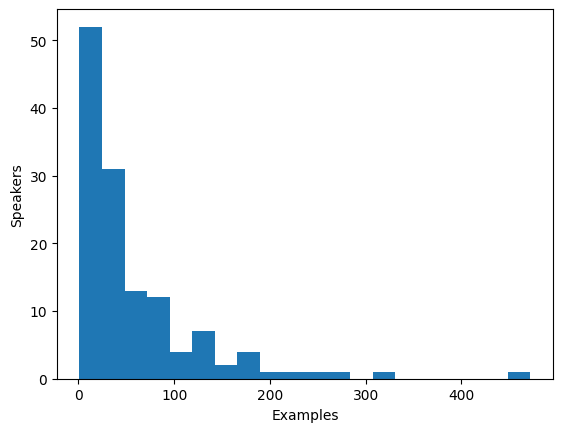

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

La gran mayoria de los hablantes tiene menos de 100 ejemplos. Aproximadamente diez o más hablantes tienen más de 500 ejemplos. Para acelerar el entrenamiento, limitemos el conjunto de datos a hablantes que tengan entre 100 y 400 ejemplos. Esto también hace que el conjunto de datos sea más equilibrado.


In [ ]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter:   0%|          | 0/7638 [00:00<?, ? examples/s]

Veamos cuantas voces quedad

In [ ]:
len(set(dataset["speaker_id"]))

21

Y el numero de ejemplos

In [ ]:
len(dataset)

3559

Tenemos caci 3600 ejemplos y unos 21 hablantes o voces

Nota: Sería aún mejor incluir la longitud de los ejemplos. Es bastante posible que los hablantes con pocos ejemplos tengan bastante audio disponible si esos ejemplos son relativamente largos. Sin embargo, lleva un tiempo escanear todo el conjunto de datos para encontrar esta información (ya que eso requiere cargar y decodificar cada archivo de audio), por lo que lo estamos omitiendo aquí.


## Speaker embeddings

Para permitir que el modelo TTS distinga entre múltiples hablantes, necesitaremos crear un **embedding** de hablante para cada ejemplo. El **embedding** del hablante es simplemente una entrada adicional al modelo que captura las características vocales de un hablante particular.

Para crear los **embeddings** de hablante, utilizamos el modelo [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) de SpeechBrain. Lo siguiente define una función `create_speaker_embedding()` que toma una forma de onda de audio de entrada y devuelve un vector de 512 elementos que contiene el **embedding** correspondiente al hablante.


In [ ]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

# Definimos el nombre del modelo del embebido de hablante que vamos a utilizar
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

# Establecemos el dispositivo en "cuda" si hay GPU disponible, o "cpu" en caso contrario
device = "cuda" if torch.cuda.is_available() else "cpu"

# Cargamos el modelo preentrenado para la clasificación de hablantes
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,  # El nombre del modelo de hablante preentrenado
    run_opts={"device": device},  # Opciones para ejecutar el modelo en el dispositivo (GPU o CPU)
    savedir=os.path.join("/tmp", spk_model_name)  # Carpeta donde se almacenarán los pesos del modelo
)

# Función para crear el embedding del hablante a partir de la onda de audio
def create_speaker_embedding(waveform):
    with torch.no_grad():  # Desactivamos el cálculo de gradientes, ya que no necesitamos entrenar el modelo
        # Pasamos la forma de onda (audio) al modelo para obtener el embedding del hablante
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))

        # Normalizamos los embeddings para asegurar que todos estén en la misma escala
        # Normalización en el eje 2 (dim=2) porque el embedding tiene una dimensión adicional para cada batch.
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)

        # Eliminamos cualquier dimensión extra innecesaria y convertimos el tensor a un array de numpy
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()

    return speaker_embeddings  # Retornamos el embedding del hablante


<ipython-input-20-b1c17f7845f6>:3: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import EncoderClassifier


hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/autocast.py:68: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device

Nota: El modelo `speechbrain/spkrec-xvect-voxceleb` fue entrenado con habla en inglés del conjunto de datos VoxCeleb, mientras que nuestros ejemplos de entrenamiento están en español. Estamos asumiendo que este modelo aún generará **embeddings** razonables para los hablantes, pero esto puede no ser cierto. Entrenar primero un modelo X-vector en el habla objetivo, como el español, podría funcionar mejor.


## Preparando el dataset

La función `prepare_dataset` toma un solo ejemplo y utiliza el objeto `SpeechT5Processor` para tokenizar el texto de entrada y cargar el audio objetivo en un **log-mel spectrogram**. También agrega los **embeddings** del hablante como una entrada adicional.


In [ ]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Verifiquemos que el procesamiento sea correcto observando un solo ejemplo:


In [ ]:
processed_example = prepare_dataset(dataset[0])

Esto debería darnos:

- los tokens para el texto de entrada en `input_ids`
- el **embedding** del hablante en `speaker_embeddings`
- el **espectrograma** objetivo en `labels`


In [ ]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

Los tokens deberían decodificarse en el texto original, con `</s>` para marcar el final de la oración.


In [ ]:
tokenizer.decode(processed_example["input_ids"])

'y desde luego esa raz<unk> n no puede tener que ver con la explicaci<unk> n surrealista que hemos escuchado m<unk> s de una vez de que se trata de una conspiraci<unk> n izquierdista.</s>'

Los **embeddings** del hablante deberían ser un vector de 512 elementos:

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

Las **etiquetas** deberían ser un **espectrograma log-mel** con 80 bins mel.


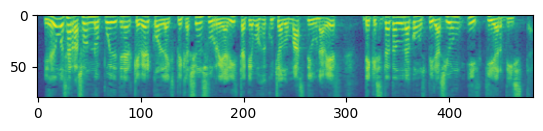

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

Si ejecutamos un **vocoder** sobre el **espectrograma log-mel**, debería producir el audio original nuevamente. Cargaremos el **vocoder HiFi-GAN** desde el **checkpoint** original de [SpeechT5](https://hf.co/microsoft/speecht5_hifigan).


In [ ]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [ ]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

¡Todo eso se ve y suena bien! Ahora podemos procesar todo el conjunto de datos. Esto tomará entre 5 y 10 minutos.


In [ ]:
dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Map:   0%|          | 0/3559 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 600). Running this sequence through the model will result in indexing errors


Algunos de los ejemplos en el conjunto de datos aparentemente son más largos que la longitud máxima de entrada que el modelo puede manejar (600 tokens), por lo que debemos eliminar esos ejemplos del conjunto de datos. De hecho, para permitir tamaños de batch más grandes, eliminaremos cualquier ejemplo que tenga más de 200 tokens.


In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/3559 [00:00<?, ? examples/s]

Veamos cuantos ejemplos quedan despues de filtrar

In [ ]:
len(dataset)

2358

## Train/test split

Creamos una división básica de entrenamiento/prueba. Para nuestros fines, está bien si el mismo hablante forma parte de ambos conjuntos.


In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

Veamos como luce nuestro dataset

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 2122
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 236
    })
})

## Collator para crear batches

Necesitamos definir un **collator** personalizado para combinar varios ejemplos en un batch. Esto rellenará las secuencias más cortas con tokens de relleno. Para las **etiquetas del espectrograma**, las porciones rellenadas se reemplazarán con el valor especial `-100`. Este valor especial le indica al modelo que ignore esa parte del espectrograma al calcular la pérdida del espectrograma.


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# Definimos una clase que representa el collation de datos para la preparación del batch
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any  # El procesador, que manejará el padding y otras transformaciones

    # El método __call__ hace que esta clase sea callable, es decir, se puede usar como una función
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        # Extraemos los input_ids de cada ejemplo en el batch
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]

        # Extraemos las características de los labels (espectrogramas) de cada ejemplo
        label_features = [{"input_values": feature["labels"]} for feature in features]

        # Extraemos los embeddings de hablante de cada ejemplo
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # Usamos el procesador para rellenar (pad) las secuencias y crear un batch
        # Se rellenan los input_ids y los labels para que tengan la misma longitud
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",  # Indicamos que los tensores devueltos sean del tipo PyTorch
        )

        # Reemplazamos las posiciones de padding en las etiquetas (labels) con el valor especial -100
        # Esto le indica al modelo que ignore esas partes al calcular la pérdida
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # Eliminamos la máscara de atención del decodificador, ya que no se usa durante el fine-tuning
        del batch["decoder_attention_mask"]

        # Si el modelo usa un factor de reducción mayor que 1 (por ejemplo, submuestreo de las secuencias),
        # redondeamos la longitud de las etiquetas para que sea un múltiplo del factor de reducción
        if model.config.reduction_factor > 1:
            # Obtenemos las longitudes de las secuencias de las etiquetas
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])

            # Redondeamos las longitudes para que sean múltiplos del factor de reducción
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])

            # Determinamos la longitud máxima y ajustamos el batch para que todas las secuencias sean de la misma longitud
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # Agregamos los embeddings de los hablantes al batch
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        # Retornamos el batch procesado con todos los datos necesarios
        return batch


En **SpeechT5**, la entrada a la parte del decodificador del modelo se reduce por un factor de 2. En otras palabras, se elimina cada otro **timestamp** de la secuencia objetivo. Luego, el decodificador predice una secuencia que es el doble de larga. Dado que la longitud original de la secuencia objetivo puede ser impar, el **collator** de datos se asegura de redondear la longitud máxima del batch hacia abajo para que sea un múltiplo de 2.


In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Probemos nuestro collator

In [ ]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [ ]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 171]),
 'attention_mask': torch.Size([3, 171]),
 'labels': torch.Size([3, 522, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

## Training

Siempre es una buena idea subir los **checkpoints** del modelo directamente al [Hugging Face Hub](https://huggingface.co/) mientras se entrena. Para permitir esto, primero debes iniciar sesión en el Hub ingresando tu token de autenticación:


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

La opción `use_cache=True` es incompatible con el **gradient checkpointing**. Desactívala durante el entrenamiento, de lo contrario, el modelo seguirá generando errores al respecto.


In [ ]:
model.config.use_cache = False

Define los **argumentos de entrenamiento**.

No vamos a calcular ninguna métrica de evaluación durante el proceso de entrenamiento. En su lugar, solo observaremos la **pérdida**. Cuanto más baja sea la pérdida, mejor será el modelo.

Nota: Si no deseas subir los **checkpoints** del modelo al Hub, establece `push_to_hub=False`.


In [ ]:
from transformers import Seq2SeqTrainingArguments

# Definimos los argumentos para el entrenamiento utilizando la clase Seq2SeqTrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_voxpopuli_es",  # Directorio donde se guardarán los checkpoints del modelo y otros resultados del entrenamiento
    per_device_train_batch_size=16,  # Tamaño de batch por dispositivo durante el entrenamiento (número de ejemplos por paso de entrenamiento)
    gradient_accumulation_steps=2,  # Número de pasos de gradiente que se acumulan antes de realizar una actualización de los pesos (útil para aumentar el tamaño efectivo del batch)
    learning_rate=1e-5,  # Tasa de aprendizaje para el optimizador (determinando la velocidad con la que el modelo ajusta sus pesos)
    warmup_steps=500,  # Número de pasos de calentamiento (warmup) antes de que la tasa de aprendizaje comience a decrecer
    max_steps=4000,  # Número máximo de pasos de entrenamiento antes de detenerse (número total de iteraciones)
    gradient_checkpointing=True,  # Habilitar el **gradient checkpointing** para ahorrar memoria durante el entrenamiento (especialmente útil con modelos grandes)
    fp16=True,  # Usar precisión de 16 bits en lugar de 32 bits para reducir el uso de memoria y acelerar el entrenamiento
    evaluation_strategy="steps",  # Realizar evaluaciones durante el entrenamiento en pasos específicos
    per_device_eval_batch_size=8,  # Tamaño de batch durante la evaluación (por dispositivo)
    save_steps=1000,  # Guardar un checkpoint cada 1000 pasos de entrenamiento
    eval_steps=1000,  # Evaluar el modelo cada 1000 pasos
    logging_steps=25,  # Registrar información de entrenamiento cada 25 pasos (para ver el progreso)
    report_to=["tensorboard"],  # Enviar los registros de entrenamiento a **TensorBoard** para su visualización
    load_best_model_at_end=True,  # Cargar automáticamente el mejor modelo (según el rendimiento en evaluación) al final del entrenamiento
    greater_is_better=False,  # Indicar si las métricas de evaluación deben ser mejores cuando son más pequeñas o más grandes (en este caso, se espera que la pérdida sea más baja)
    label_names=["labels"],  # Especificar el nombre de las etiquetas en el modelo (se usa para hacer seguimiento de la pérdida)
    push_to_hub=True,  # Subir los checkpoints y el modelo entrenado al **Hugging Face Hub** para almacenamiento y uso posterior
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1570: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Crea el objeto **trainer** utilizando el modelo, el conjunto de datos y el **data collator**.


In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

<ipython-input-46-4a9303382841>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


¡Y con eso, estamos listos para comenzar el entrenamiento!

El entrenamiento tomará varias horas dependiendo de tu GPU o de la que esté asignada en Google Colab. Dependiendo de tu GPU, es posible que encuentres un error de "out-of-memory" de **CUDA** cuando comiences el entrenamiento. En ese caso, puedes reducir el **`per_device_train_batch_size`** de manera incremental en factores de 2 y aumentar **`gradient_accumulation_steps`** por 2x para compensar.


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
1000,0.496000,0.468627
2000,0.480800,0.457431
3000,0.478100,0.455880


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2774: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.496000,0.468627
2000,0.480800,0.457431
3000,0.478100,0.455880
4000,0.473900,0.455179


TrainOutput(global_step=4000, training_loss=0.5072376139163971, metrics={'train_runtime': 8055.8101, 'train_samples_per_second': 15.889, 'train_steps_per_second': 0.497, 'total_flos': 2.056217959052928e+16, 'train_loss': 0.5072376139163971, 'epoch': 59.70676691729323})

In [ ]:
#cargar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

# Ruta de destino en tu Google Drive
dest_path = "/content/drive/MyDrive/speecht5_tts_voxpopuli_es/checkpoint-4000"

# Ruta de origen
source_path = "/content/speecht5_tts_voxpopuli_es/checkpoint-4000"

# Mover la carpeta
shutil.move(source_path, dest_path)

print(f"Carpeta movida a {dest_path}")

Carpeta movida a /content/drive/MyDrive/speecht5_tts_voxpopuli_es/checkpoint-4000


## Evaluar

Después de que termine el entrenamiento, ¡vamos a usar el modelo para sintetizar algo de habla!



In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained("/content/speecht5_tts_voxpopuli_es/checkpoint-4000")

Primero necesitamos obtener una **embedding** del hablante. Podemos simplemente tomar una del conjunto de prueba.


In [ ]:
example = dataset["test"][234]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Define un texto de entrada y tokenízalo.


In [ ]:
text = "Bienvenido al sistema"

In [ ]:
#tokenizer.decode(tokenizer(text)["input_ids"])

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Indica al modelo que genere un espectrograma a partir del texto de entrada.


In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

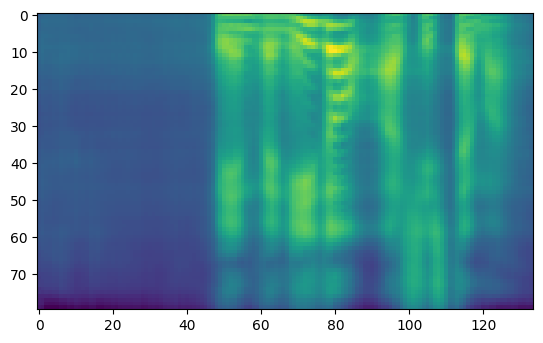

In [ ]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finalmente, usa el **vocoder** para convertir el espectrograma en sonido.


In [ ]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [ ]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)

Una nota final sobre preocupaciones éticas: aunque la tecnología TTS tiene muchos usos beneficiosos, también puede ser utilizada para fines nefastos, como imitar la voz de alguien sin su permiso. ¡Por favor, usa la tecnología TTS de manera sabia y responsable!
